# Trabajo Práctico 2: Análisis con Redes Neuronales - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Configuraciones Iniciales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(1)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeHoldout
from preprocessing import prepararSetDeValidacion
from preprocessing import redesNeuronalesPreprocessing

In [5]:
from funcionesAuxiliares import escribirPrediccionesAArchivo

## Carga y preparacion del set de datos

Cargamos los sets de datos que se usaran para el entrenamiento y validacion.

In [6]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

## Funciones Auxiliares


In [7]:
def obtenerMejoresHiperparametros(datosPreprocesados):
    
    return 0

In [8]:
def graficarPerdidaDelModelo(historia_modelo):
    plt.figure(dpi=125, figsize=(10, 3))
    plt.plot(historia_modelo.history['loss'], label="Training loss")
    plt.plot(historia_modelo.history['val_loss'], label="Validation loss")
    plt.title('Loss del modelo')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [9]:
def entrenarModelo(modelo, epocas, tamanio_entrenamiento):
    historia = modelo.fit(X_train, y_train, epochs=epocas, batch_size=tamanio_entrenamiento, verbose=0, validation_split=0.25)
    return historia, modelo

In [10]:
def graficarROCCurve(modelo,nombreModelo,X_test, X_train, y_test, y_train):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, modelo.predict_proba(X_test))
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train))

    zero_test = np.argmin(np.abs(thresholds_test))
    zero_train = np.argmin(np.abs(thresholds_train))

    plt.plot(fpr_test, tpr_test, label="ROC Curve "+nombreModelo+" Test")
    plt.plot(fpr_train, tpr_train, label="ROC Curve  " + nombreModelo + " Train")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr_test[zero_test], tpr_test[zero_test], 'o', markersize=10, label="threshold zero test",
             fillstyle="none", c="k", mew=2)
    plt.plot(fpr_train[zero_train], tpr_train[zero_train], 'x', markersize=10, label="threshold zero train",
             fillstyle="none", c="k", mew=2)
    plt.legend(loc=4)
    plt.show()

## Redes Neuronales

Las redes neuronales estan dentro de lo que se considera modelos mas complejos. Este tipo de modelo dispone de una amplia cantdidad de parametros que se pueden ir modificando hasta obtener los mejores resultados.

Para el preprocesamiento decidimos utilizar el mismo tipo de funcion que en otros modelos. Este preprocesamiento encodea las variables categoricas mediante OneHotEncoding y normaliza las variables numericas.

In [11]:
X_redes_neuronales = redesNeuronalesPreprocessing(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_redes_neuronales, y, test_size=0.25, random_state=0)

Los **parametros** que tendremos en cuenta al entrenar las redes neuronales seran:

* **Funcion de perdida a optimizar:** Es la funcion que se busca minimizar. En nuestro caso como deseamos hacer una clasificacion binaria, es decir, entre dos classes, utilizaremos siempre la funcion: binary cross entropy

* **Optimizador:** Es el algoritmo mediante el cual se optimiza el funcion de perdida anterior. Utilizaremos Stochastic Gradient Descent (SGD) y Adam. La diferencia principal radica en que Adam es un optimizador que considera a la derivada segunda para realizar la optimizacion mientras que SGD solo la derivada primera. Esto puede llegar a suavizar la perida al entrenar la red a lo largo de las epocas. 

* **Tasa de aprendizaje:** Es un parametro que indica la velocidad con la cual el optimizador intenta acercarse el minimo de la funcion de perdida. Una tasa pequenia, requerira mas iteraciones para alcanzar el minimo y una muy grande podria nunca encontrarlo, por ejemplo ya que se lo saltea constantemente.

* **Funcion de activacion de las neuronas:** Es la funcion que se aplica sobre el input de cada neurona, antes de multiplicarla por el peso correspondiente. Hemos probado las siguientes: ReLu, sigmoidea y tanh

* **Cantidad de capas:** Es la cantidad de capas de la red. Consideramos que teniendo una capa de input, una oculta y una de output era suficiente. Esto es porque agregando capas el tiempo de entrenamiento se volvia poco razonable y posiblemente mas complicado de lo necesario.

* **Cantidad de neuronas de cada capa:** Hemos entrenado con la siguiente configuracion de la red: La primera capa tiene 14 neuronas pues tenemos 14 features. La ultima capa tiene 1, lo cual nos servira para realiar la clasificacion en los 2 

Ademas, en algunas redes, utilizamos **dropout:** durante el entrenamiento, algunas de las neuronas no se tienen en cuenta. Esto puede volver mas robusto al modelo, al hacer que la salida del mismo no depende unicamente de un camino.

////////////////Ver si usamos regularizacion l1 o l2

Empezamos ahora armando una red neuronal sencilla para ver como es su desempeño.

In [13]:
red_neuronal1 = Sequential()
red_neuronal1.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal1.add(Dense(6, activation='tanh'))
red_neuronal1.add(Dense(1, activation='sigmoid'))
red_neuronal1.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

Mostramos el resumen de como queda armada.

In [14]:
red_neuronal1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


Ahora finalmente entrenamos con el set de entrenamiento.

In [15]:
h, red_neuronal1 = entrenarModelo(red_neuronal1, 500, 50)

Observamos como se fue desarrollando la funcion de perdida para el entrenamiento y la validacion de la red.

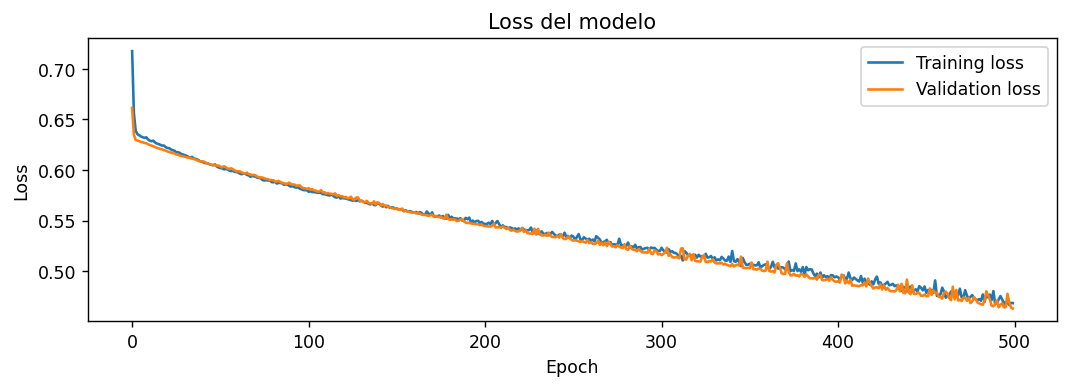

In [16]:
graficarPerdidaDelModelo(h)

Ahora buscamos las metricas que nos interesan sobre el set de evaluacion guardado anteriormente.

In [17]:
y_pred = red_neuronal1.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.76      0.86      0.81       121
      Vuelve       0.74      0.60      0.66        80

    accuracy                           0.76       201
   macro avg       0.75      0.73      0.74       201
weighted avg       0.75      0.76      0.75       201



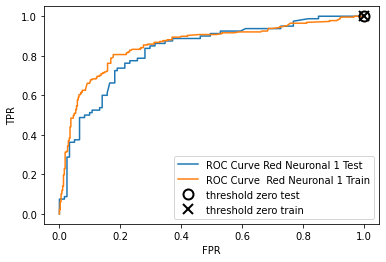

In [19]:
graficarROCCurve(red_neuronal1,"Red Neuronal 1",X_test, X_train, y_test, y_train)

In [20]:
auc_red = roc_auc_score(y_test,red_neuronal1.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.829


Vemos que se obtuvieron resultados que estan bien, pero que pueden mejorarse. Una cosa que se destaca es que en el grafico del entrenamiento aparece como que todavia puede seguir aprendiendo. Probamos aumentando la cantidad de epocas.

In [21]:
red_neuronal2 = Sequential()
red_neuronal2.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal2.add(Dense(6, activation='tanh'))
red_neuronal2.add(Dense(1, activation='sigmoid'))
red_neuronal2.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

In [22]:
h, red_neuronal2 = entrenarModelo(red_neuronal2, 800, 50)

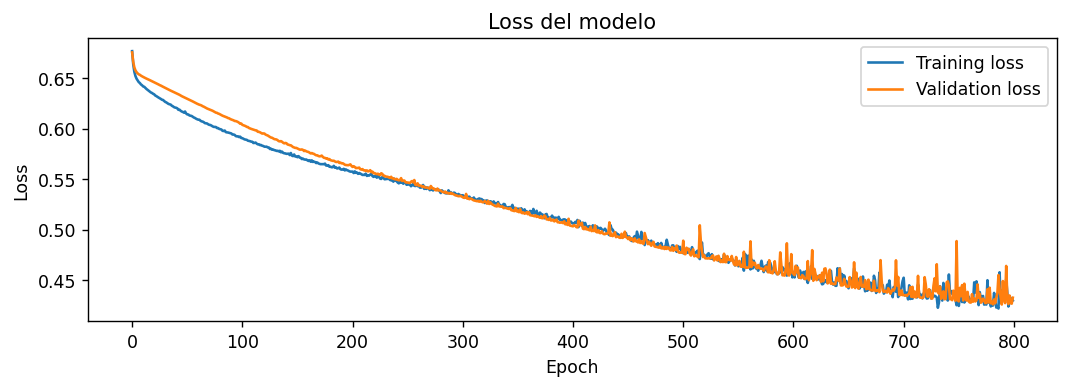

In [23]:
graficarPerdidaDelModelo(h)

In [24]:
y_pred = red_neuronal2.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.84      0.79      0.81       121
      Vuelve       0.70      0.78      0.74        80

    accuracy                           0.78       201
   macro avg       0.77      0.78      0.78       201
weighted avg       0.79      0.78      0.78       201



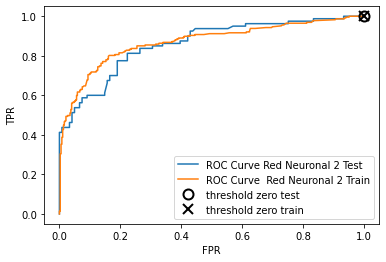

In [26]:
graficarROCCurve(red_neuronal2,"Red Neuronal 2",X_test, X_train, y_test, y_train)

In [27]:
auc_red = roc_auc_score(y_test,red_neuronal2.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.860


Vemos que aprendio algo mas y mejoro la metrica, pero que ya en el entrenamiento se empiezan a ver picos hacia el final. Probamos mejorarlo cambiando el optimizador a 'Adam'.

In [28]:
red_neuronal3 = Sequential()
red_neuronal3.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal3.add(Dense(6, activation='tanh'))
red_neuronal3.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal3.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [29]:
h, red_neuronal3 = entrenarModelo(red_neuronal3, 800, 50)

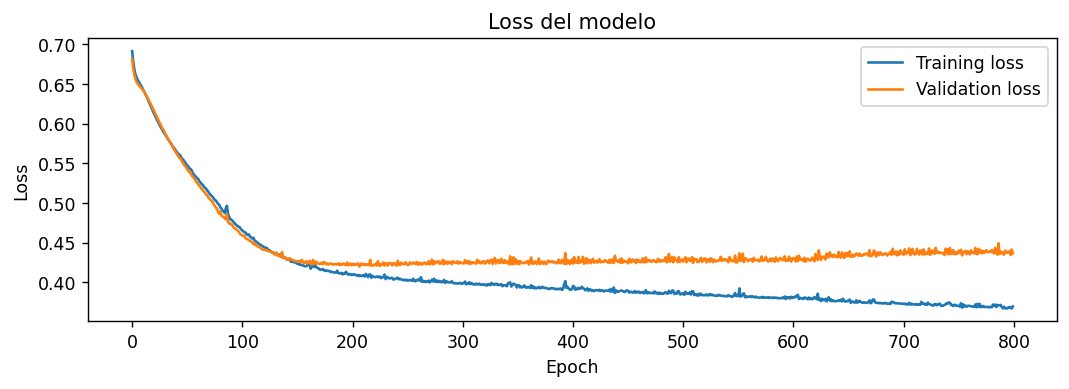

In [30]:
graficarPerdidaDelModelo(h)

In [31]:
y_pred = red_neuronal3.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.83      0.90      0.87       121
      Vuelve       0.83      0.72      0.77        80

    accuracy                           0.83       201
   macro avg       0.83      0.81      0.82       201
weighted avg       0.83      0.83      0.83       201



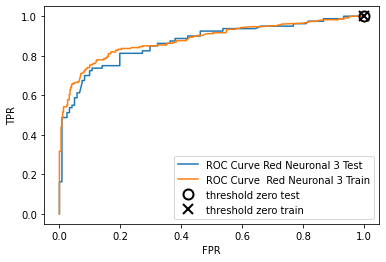

In [33]:
graficarROCCurve(red_neuronal3,"Red Neuronal 3",X_test, X_train, y_test, y_train)

In [34]:
auc_red = roc_auc_score(y_test,red_neuronal3.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.869


Vemos que volvio a mejorar. Probamos agregando algunas capas de 'Dropout', asi no empieza a separarse hacia el final la funcion de perdida.

In [35]:
red_neuronal4 = Sequential()
red_neuronal4.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal4.add(Dropout(0.1))
red_neuronal4.add(Dense(6, activation='tanh'))
red_neuronal4.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal4.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [36]:
h, red_neuronal4 = entrenarModelo(red_neuronal4, 800, 50)

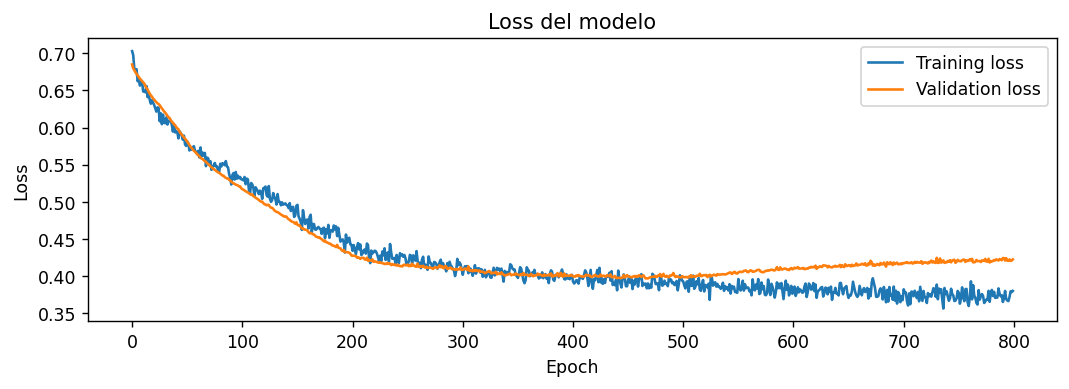

In [37]:
graficarPerdidaDelModelo(h)

In [38]:
y_pred = red_neuronal4.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.84      0.94      0.89       121
      Vuelve       0.89      0.72      0.80        80

    accuracy                           0.86       201
   macro avg       0.87      0.83      0.84       201
weighted avg       0.86      0.86      0.85       201



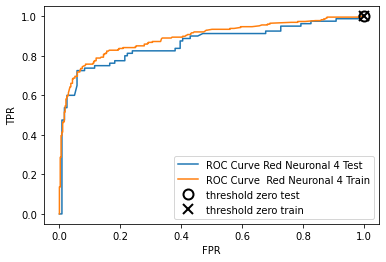

In [40]:
graficarROCCurve(red_neuronal4,"Red Neuronal 4",X_test, X_train, y_test, y_train)

In [41]:
auc_red = roc_auc_score(y_test,red_neuronal4.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.862


Se pudo observar otra ligera mejora. Intentamos mejorarlo aun mas ahora agregando una capa mas junto a un dropout.

In [42]:
red_neuronal5 = Sequential()
red_neuronal5.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal5.add(Dropout(0.1))
red_neuronal5.add(Dense(14, activation='relu'))
red_neuronal5.add(Dropout(0.1))
red_neuronal5.add(Dense(6, activation='tanh'))
red_neuronal5.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal5.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [43]:
h, red_neuronal5 = entrenarModelo(red_neuronal5, 800, 50)

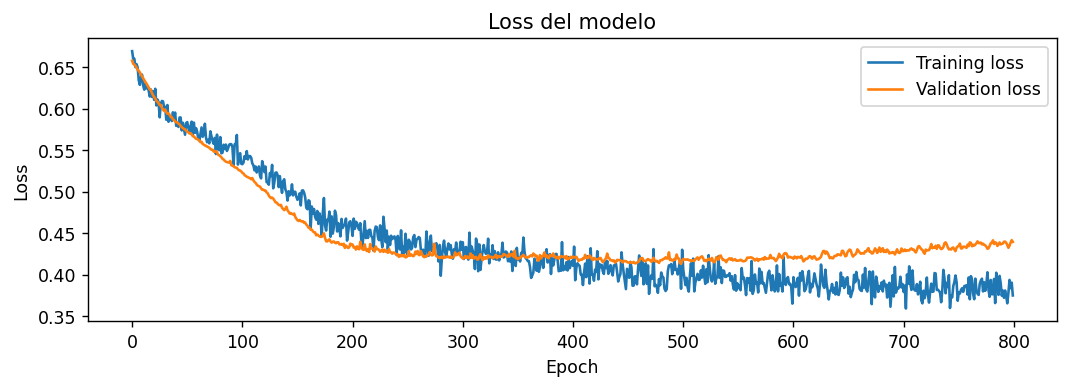

In [44]:
graficarPerdidaDelModelo(h)

In [45]:
y_pred = red_neuronal5.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.82      0.86      0.84       121
      Vuelve       0.77      0.71      0.74        80

    accuracy                           0.80       201
   macro avg       0.79      0.79      0.79       201
weighted avg       0.80      0.80      0.80       201



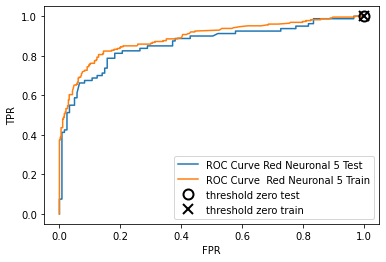

In [47]:
graficarROCCurve(red_neuronal5,"Red Neuronal 5",X_test, X_train, y_test, y_train)

In [48]:
auc_red = roc_auc_score(y_test,red_neuronal5.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.861


Habiendo hecho esto, el valor de la metrica AUC se vio reducido.

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado anteriormente.

In [49]:
holdout = pd.read_csv('Datasets/tp-2020-2c-holdout-cols2.csv')

holdout = prepararSetDeHoldout(holdout)
holdout_redes = redesNeuronalesPreprocessing(holdout)

Realizamos las predicciones y escribimos al archivo CSV.

In [50]:
predicciones_holdout = red_neuronal5.predict(holdout_redes) #ver que numero de red utilizar

In [52]:
escribirPrediccionesAArchivo(predicciones_holdout.round(),"RedesNeuronales")